### Description

#### Evaluates a number of estimators to construct the Voting Regressor meta-estimator with weights such that the mean squared error of the combined predictions of the estimators is minimized.

#### version: 1.1

#### TODO:
- remove unused imports
- finalize estimator selection
- estimator comp. df
- finalize 'fine tuning'
- save final estimators
- save final voting regressor
- plot results
- general file cleanup

### Done:
- prune features
- full db integration

In [5]:
# Import Dependencies
import pandas as pd
import numpy as np
import joblib

from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

# Plots as needed
import matplotlib.pyplot as plt
import seaborn as sns

# Pre-processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Data split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

# Model
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import ARDRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import HuberRegressor


# Model Validation and Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from scipy import stats

# MSE minimization
from sklearn.metrics import mean_squared_error
from scipy import optimize

# DB interface
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from config import db_password

## Interface with Database and create DataFrames

In [2]:
# Construct db string
user = 'postgres'
host = 'housing-prices.ch2ctomvepex.us-east-1.rds.amazonaws.com'
name = 'housing-prices'

db_string = f'postgresql://{user}:{db_password}@{host}/{name}'

In [3]:
# Create Connection Engine

engine = create_engine(db_string)

In [24]:
# map to Base to extract metadata
Base = automap_base()
Base.prepare(engine, reflect=True)

In [27]:
# List of tables corresponding to cities
table_names = []
city_list = ['austin','boston','sanfran','chandler','chicago','houston','la','pittsburgh','spokane']

for k in Base.metadata.tables.keys():
    if k in city_list:
        table_names.append(k)

print(table_names)

['austin', 'sanfran', 'la', 'boston', 'chandler', 'pittsburgh', 'houston', 'spokane', 'chicago']


In [29]:
# Create df from comb. of all city tables

def city_df(eng,city_tables):
    
    all_pop = pd.DataFrame()
    
    for city in city_tables:
        
        # Create temp city df
        city = pd.read_sql_table(city, eng)
        
        # add to all_pop
        all_pop = pd.concat([all_pop,city])
        
    return all_pop

In [30]:
all_pop = city_df(eng=engine,city_tables=table_names)
all_pop.head()

,price,bedroom,sqft,bathroom,amenity_count,cityid
0,1191,1,600.0,1.0,5,1
1,1425,1,526.0,1.0,5,1
2,1266,1,578.0,1.0,5,1
3,1144,1,351.0,1.0,8,1
4,1775,4,1236.0,2.0,8,1


In [17]:
# Example Data from CSV used here

# Import Data
sf_df = pd.read_csv("../../First Segment Rubric - Sample Data/sf_clean.csv")
sf_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


## Temp Data from CSVs

In [2]:
# # Create city list and general path

# # TODO: Edit to match RDS table names
# city_list = ['austin','boston','sf','chandler','chicago','houston','la','pittsburgh','spokane']

# # Group by city population
# low_list = ['chandler', 'pittsburgh', 'spokane']
# mid_list = ['austin', 'boston', 'sf']
# high_list = ['chicago', 'la', 'houston']

# # TODO: Edit to match RDS path
# general_path = '../../First Segment Rubric - Clean/csv/'

In [3]:
# # Create dataframes for each pop grouping and overall


# def build_dfs(cities, gen_path, lowpop_list=[], midpop_list=[], highpop_list=[]):
    
#     # Dummy cityID for cities temp. missing it
#     dummy_id = 10

#     low_pop = pd.DataFrame()
#     mid_pop = pd.DataFrame()
#     high_pop = pd.DataFrame()
#     all_pop = pd.DataFrame()

#     # Iterate through cities to get data
#     for city in cities:
        
#         city_fp = f'{gen_path}{city}_clean_data.csv'
        
        
#         # Determine low, mid, or high pop
        
#         if city in lowpop_list:
            
#             # Create temp city df
#             city = pd.read_csv(city_fp)
        
#             # Check for cityID
#             if city.columns[-1] != 'cityID':
#                 city['cityID'] = dummy_id
#                 dummy_id = dummy_id + 1
                
#             # Check for num amen
#             if 'number of amenities' in city.columns:
#                 city['amenity_count'] = city['number of amenities']
#                 city = city.drop(columns='number of amenities', axis=1)
                
#             # Add class col
#             city['pop_class'] = 1
            
#             # Add to low df
#             low_pop = pd.concat([low_pop,city])
                
#         elif city in midpop_list:
            
#            # Create temp city df
#             city = pd.read_csv(city_fp)
        
#             # Check for cityID
#             if city.columns[-1] != 'cityID':
#                 city['cityID'] = dummy_id
#                 dummy_id = dummy_id + 1
            
#             # Check for num amen
#             if 'number of amenities' in city.columns:
#                 city['amenity_count'] = city['number of amenities']
#                 city = city.drop(columns='number of amenities', axis=1)
            
#             # Add class col
#             city['pop_class'] = 2
            
#             # Add to mid df
#             mid_pop = pd.concat([mid_pop,city])
                
#         elif city in highpop_list:
            
#             # Create temp city df
#             city = pd.read_csv(city_fp)
        
#             # Check for cityID
#             if city.columns[-1] != 'cityID':
#                 city['cityID'] = dummy_id
#                 dummy_id = dummy_id + 1
                
#             # Check for num amen    
#             if 'number of amenities' in city.columns:
#                 city['amenity_count'] = city['number of amenities']
#                 city = city.drop(columns='number of amenities', axis=1)
            
#             # Add class col
#             city['pop_class'] = 3
            
#             # Add to high df
#             high_pop = pd.concat([high_pop,city])
        
        
#         # add to all_pop
        
#         all_pop = pd.concat([all_pop,city])
        
        
#     return low_pop, mid_pop, high_pop, all_pop

In [30]:
# # Call fn to create dfs
# low_pop, mid_pop, high_pop, all_pop = build_dfs(city_list, general_path, low_list,
#                                                mid_list, high_list)

## Examine data

In [31]:
all_pop.describe()

,price,bedroom,sqft,bathroom,amenity_count,cityid
count,4848.000000,4848.000000,4848.000000,4848.000000,4848.000000,4848.000000
mean,1992.465140,1.668317,937.918936,1.459571,5.587871,4.956271
std,1188.873793,0.960823,499.195650,0.638668,1.863872,2.668800
min,225.000000,0.000000,1.000000,0.000000,0.000000,1.000000
25%,1350.000000,1.000000,665.000000,1.000000,4.000000,3.000000
50%,1700.000000,2.000000,869.000000,1.000000,6.000000,5.000000
75%,2370.000000,2.000000,1118.250000,2.000000,7.000000,7.000000
max,27000.000000,8.000000,15492.000000,5.500000,11.000000,9.000000


In [32]:
# Check dtypes
all_pop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4848 entries, 0 to 362
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          4848 non-null   int64  
 1   bedroom        4848 non-null   int64  
 2   sqft           4848 non-null   float64
 3   bathroom       4848 non-null   float64
 4   amenity_count  4848 non-null   int64  
 5   cityid         4848 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 265.1 KB


In [33]:
# Check num unique values
all_pop.nunique().sort_values()

bedroom             9
cityid              9
bathroom           11
amenity_count      11
sqft              987
price            1284
dtype: int64

### Treat Appropriate Features as Categorical

In [86]:
# Treat features with fewer than 15 unique values as cat

num_unq = all_pop.drop(columns='price').nunique().sort_values()

num_ft, cat_ft = [], []

for i in range(all_pop.drop(columns='price').shape[1]):
    
    if num_unq.values[i] < 15:
        cat_ft.append(num_unq.index[i])
    else:
        num_ft.append(num_unq.index[i])

print(num_ft)
print(cat_ft)

['sqft']
['bedroom', 'cityid', 'bathroom', 'amenity_count']


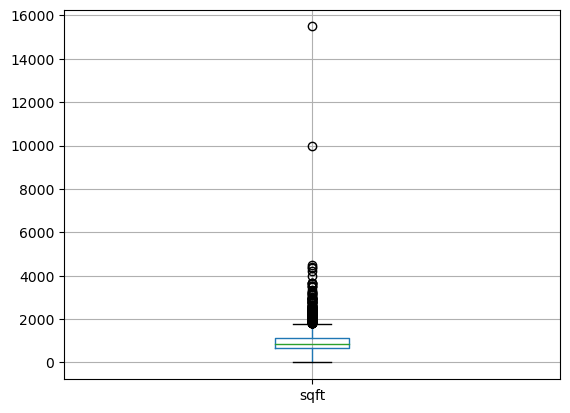

In [126]:
# Dist of num ft 'sqft' -> appears many outside 1.5*IQR
all_t.boxplot(column='sqft')
plt.show()

In [128]:
all_t.drop(all_t[all_t.sqft > upper].index, inplace=True)

In [125]:
all_t = all_pop.copy()

# for ft in cat_ft:
#     if ft != 'cityid':
#         all_t = pd.concat([all_t,pd.DataFrame(pd.get_dummies(all_t[ft],
#                                                                        prefix=ft))],axis=1)
#         all_t.drop(columns=ft,axis=1,inplace=True)
# all_t.head()

In [127]:
# Calc iqr of sqft and upper/lower bounds
sqft_iqr = all_t.sqft.quantile(.75)-all_t.sqft.quantile(.25)
upper = 1.5*sqft_iqr + all_t.sqft.quantile(.75)
lower =  all_t.sqft.quantile(.25) - 1.5*sqft_iqr
print(lower)
print(upper)

-14.875
1798.125


In [148]:
all_t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3535 entries, 0 to 362
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          3535 non-null   int64  
 1   bedroom        3535 non-null   int64  
 2   sqft           3535 non-null   float64
 3   bathroom       3535 non-null   float64
 4   amenity_count  3535 non-null   int64  
 5   cityid         3535 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 193.3 KB


## Split Train and Test Data

In [129]:
# Before examination, split so that the test set remains unobserved

# Split using SSS to incorporate data from each of the 3 groups in test and train sets.
split = StratifiedShuffleSplit(n_splits=10,test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_t, all_t['cityid']):
    strat_train_set = all_t.iloc[train_index]
    strat_test_set = all_t.iloc[test_index]

In [130]:
# Create a new df that is a copy of the training set to preserve it.
all_train = strat_train_set.copy()

# Repeat for test set
all_test = strat_test_set.copy()

# Show first 5 rows of training set
all_train.head()

,price,bedroom,sqft,bathroom,amenity_count,cityid
182,2995,3,1150.0,2.0,6,6
132,1605,2,983.0,2.0,5,5
194,1195,2,1100.0,1.0,6,9
338,1771,2,1121.0,2.0,3,5
216,1799,2,1076.0,2.0,6,5


In [39]:
# Compare Train Test Split
train_set,test_set = train_test_split(all_t, test_size=0.2, random_state=42)

In [41]:
# df for comparison of test sets
split_comp = pd.DataFrame()
split_comp['Overall'] = all_t.cityid.value_counts() / len(all_t.cityid)
split_comp['Strat_City'] = all_test.cityid.value_counts() / len(all_test.cityid)
split_comp['Random'] = test_set.cityid.value_counts() / len(test_set.cityid)
split_comp['Random %Error'] = ((split_comp.Random - split_comp.Overall) / split_comp.Overall)*100
split_comp['Strat_City %Error'] = ((split_comp.Strat_City - split_comp.Overall) / split_comp.Overall)*100
split_comp

,Overall,Strat_City,Random,Random %Error,Strat_City %Error
5,0.145008,0.145361,0.125773,-13.264800,0.243141
1,0.141089,0.141237,0.160825,13.988063,0.104901
3,0.140883,0.141237,0.151546,7.569093,0.251468
9,0.140058,0.140206,0.138144,-1.366169,0.105978
7,0.110355,0.110309,0.111340,0.892957,-0.041237
8,0.086427,0.086598,0.065979,-23.659179,0.197328
4,0.085602,0.085567,0.089691,4.776053,-0.041237
2,0.075701,0.075258,0.074227,-1.947808,-0.585972
6,0.074876,0.074227,0.082474,10.147397,-0.867343


#### Stratified Shuffle Split demonstrates better representation of the population groupings

In [131]:
# Drop columns not used in analysis
all_train.drop(columns=['cityid'],axis=1,inplace=True)
all_test.drop(columns=['cityid'],axis=1,inplace=True)

### Preprocess Finalized Feature Set

In [132]:
# Remove target

X_train = all_train.drop(columns='price').values
y_train = all_train.price.values

X_test = all_test.drop(columns='price').values
y_test = all_test.price.values

In [133]:
# Scale using RobustScaler due to spread

rs = RobustScaler()

robust = rs.fit(X_train)

X_train_scaled = robust.transform(X_train)

X_test_scaled = robust.transform(X_test)

## Estimator Construction

In [45]:
# Create fn to out scores from cross_val_score to select estimators

def score_info(scores):
    MSE = -scores
    confidence = 0.95
    con_int= stats.t.interval(
    confidence,
    len(MSE)-1,
    loc=MSE.mean(),
    scale=stats.sem(MSE))
    
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}')
    print(f'Conf. Interval: {con_int}')
    return [MSE.mean(), MSE.std(), con_int[0], con_int[1]]

In [134]:
# Gradient Boosting Regressor

gbr_cvs = cross_val_score(GradientBoostingRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

gbr_score = score_info(gbr_cvs)

Mean: 662478.3825001642
STD: 102044.63428137738
Conf. Interval: (603984.5252181767, 720972.2397821518)


In [135]:
# Random Forest Regressor

rfr_cvs = cross_val_score(RandomForestRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

rfr_score =score_info(rfr_cvs)

Mean: 675854.324006696
STD: 114881.78360275742
Conf. Interval: (610001.9771225814, 741706.6708908106)


In [136]:
# Lasso

lasso_cvs = cross_val_score(LassoCV(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

lasso_score=score_info(lasso_cvs)

Mean: 756698.0909064644
STD: 108054.38875902574
Conf. Interval: (694759.332055757, 818636.8497571717)


In [137]:
# Ridge

ridge_cvs = cross_val_score(RidgeCV(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ridge_score=score_info(ridge_cvs)

Mean: 757604.5325728253
STD: 107821.64660933688
Conf. Interval: (695799.1857940342, 819409.8793516165)


In [138]:
# Adaboost

ada_cvs = cross_val_score(AdaBoostRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ada_score=score_info(ada_cvs)

Mean: 964186.5970011249
STD: 116660.88471676885
Conf. Interval: (897314.4367051041, 1031058.7572971457)


In [139]:
#ARDRegression

ard_cvs = cross_val_score(ARDRegression(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

ard_score=score_info(ard_cvs)

Mean: 756226.1554470676
STD: 107481.94240676714
Conf. Interval: (694615.5333520693, 817836.7775420658)


In [140]:
# SVM with polynomial kernel

svp_cvs = cross_val_score(SVR(kernel='poly'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svp_score = score_info(svp_cvs)

Mean: 885884.2620191523
STD: 133871.29129374793
Conf. Interval: (809146.7807959879, 962621.7432423166)


In [141]:
svl_cvs = cross_val_score(SVR(kernel='linear'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svl_score = score_info(svl_cvs)

Mean: 873512.794551439
STD: 133973.97505385077
Conf. Interval: (796716.4531123413, 950309.1359905367)


In [142]:
svr_cvs = cross_val_score(SVR(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svr_score = score_info(svr_cvs)

Mean: 932262.250711153
STD: 142841.52767134487
Conf. Interval: (850382.8653579779, 1014141.6360643281)


In [143]:
svs_cvs = cross_val_score(SVR(kernel='sigmoid'),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

svs_score = score_info(svs_cvs)

Mean: 903769.2089114421
STD: 138952.16498089558
Conf. Interval: (824119.2776372116, 983419.1401856726)


In [144]:
# K nearest regression

knn_cvs = cross_val_score(KNeighborsRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

knn_score = score_info(knn_cvs)

Mean: 725980.79302638
STD: 134981.40974417498
Conf. Interval: (648606.9715324834, 803354.6145202767)


In [145]:
bag_cvs = cross_val_score(BaggingRegressor(random_state=42),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

bag_score= score_info(bag_cvs)

Mean: 720738.2263654224
STD: 122639.82355438708
Conf. Interval: (650438.8285911328, 791037.624139712)


In [146]:
hbr_cvs = cross_val_score(HuberRegressor(),X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

huber_score = score_info(hbr_cvs)

Mean: 799127.8284758372
STD: 126502.08152644917
Conf. Interval: (726614.5135446585, 871641.143407016)


In [112]:
mod_type = ['Tree','Tree','Lin','Lin','Tree','Lin','Poly','Lin',
                       'RBF','Logistic','Cluster','Tree','Lin']
est_pre = pd.DataFrame([gbr_score,rfr_score,lasso_score,ridge_score,
                       ada_score,ard_score,svp_score,svl_score,
                        svr_score,svs_score,knn_score,bag_score,huber_score],
                       columns=['Mean MSE','Stdev MSE','CI Low','CI High'],
                       index=['GBR','RFR','Lasso','Ridge','AdaB','ARD','SVR(Poly)',
                              'SVR(rbf)','SVR(linear)','SVR(sigmoid)','Knearest',
                             'Bagging(tree)','Huber'])
est_pre['Model_Type'] = mod_type

In [113]:
est_pre.sort_values(by=['Mean MSE','Stdev MSE'])

,Mean MSE,Stdev MSE,CI Low,CI High,Model_Type
GBR,659614.006862,106456.351211,598591.272464,7.206367e+05,Tree
RFR,666772.794803,116491.539687,599997.706187,7.335479e+05,Tree
Knearest,704433.577897,116734.611288,637519.156177,7.713480e+05,Cluster
Bagging(tree),706375.524874,116598.198057,639539.297722,7.732118e+05,Tree
ARD,726481.933522,109858.156004,663509.222181,7.894546e+05,Lin
Lasso,726692.905579,107077.069926,665314.363820,7.880714e+05,Lin
Ridge,727008.057368,107221.761555,665546.575713,7.884695e+05,Lin
Huber,762378.680349,121781.769845,692571.134709,8.321862e+05,Lin
SVR(rbf),871354.529991,133237.978080,794980.075526,9.477290e+05,Lin
SVR(Poly),908242.651172,139111.554766,828501.354748,9.879839e+05,Poly


In [207]:
# To-Do: Plots

## Estimator Tuning

In [65]:
def mod_imp(model):
    scores = cross_val_score(model,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)
    
    MSE = -scores
    print(f'Mean: {MSE.mean()}')
    print(f'STD: {MSE.std()}') 

In [314]:
def plot_lc(model,X_d,y_d):
    
    X, X_val, y, y_val = train_test_split(X_d,y_d, test_size=0.2, random_state=42)
    train_err = []
    val_err = []
    
    for k in range(1,len(X)):
        model.fit(X[:k],y[:k])
        y_pred = model.predict(X[:k])
        y_val_pred = model.predict(X_val)
        train_err.append(mean_squared_error(y[:k],y_pred[:k]))
        val_err.append(mean_squared_error(y_val,y_val_pred))
    
    plt.plot(train_err,'r-',label='train')
    plt.plot(val_err,'b-',label='validation')

In [ ]:
def plot_expect(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    y_pred = model.predict(X_train)
    
    plt.plot(X_train,y_train)
    plt.plot(X_test,y_test)

In [111]:
# GBR

model = GradientBoostingRegressor()


mod_params = {
    'learning_rate': np.arange(.5,.6,.05),
    'n_estimators': np.arange(7,13),
    'subsample': np.arange(.93,.97,0.005),
    'max_depth': [6,7,8],
    'random_state': [42],
    'max_features': ['sqrt'],
    'alpha': [1e-30,1e-20]
}


    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
gbr = model_cv.best_estimator_

mod_imp(gbr)

Fitting 15 folds for each of 576 candidates, totalling 8640 fits
Mean: 211603.47008663282
STD: 50431.40097446247


C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: divide by zero encountered in double_scalars
  1
C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: invalid value encountered in double_scalars
  1
C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: divide by zero encountered in double_scalars
  1
C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: invalid value encountered in double_scalars
  1
C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: divide by zero encountered in double_scalars
  1
C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ensemble\_gb_losses.py:229: RuntimeWarning: invalid value encountered in double_scalars
  1
C:\Users\Kilpa\anaconda3\envs\mlenv2\lib\site-packages\sklearn\ense

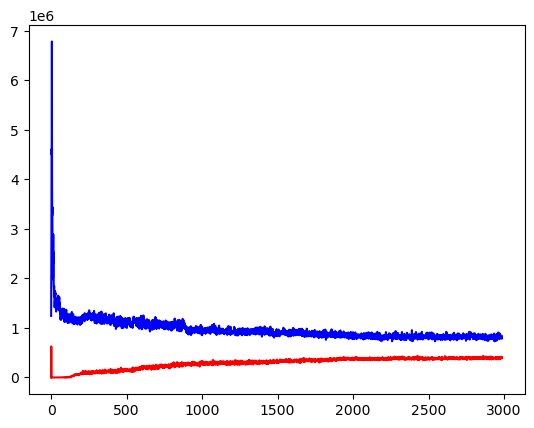

In [325]:
plot_lc(gbr,X_train_scaled,y_train)

In [112]:
# RFR

model = RandomForestRegressor()


mod_params = {
    'n_estimators': np.arange(20,40),
    'random_state': [42],
    'max_features': ['sqrt','log2']
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
rfr = model_cv.best_estimator_

mod_imp(rfr)

Fitting 15 folds for each of 40 candidates, totalling 600 fits
Mean: 206886.09895005455
STD: 40508.74146739888


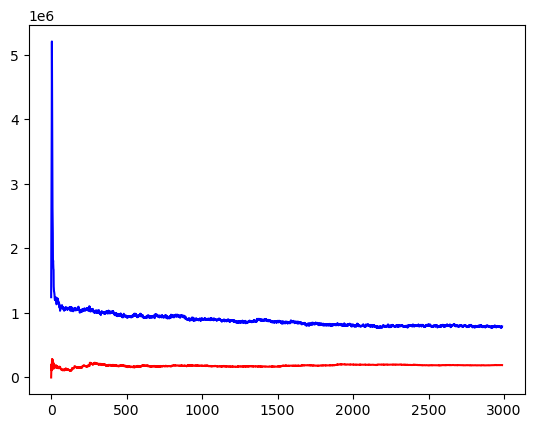

In [324]:
plot_lc(rfr,X_train_scaled,y_train)

In [113]:
# ADA

model = AdaBoostRegressor()


mod_params = {
    'learning_rate': np.arange(.1,.14,.01),
    'n_estimators': np.arange(1,15),
    'random_state': [42]
}

    
model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
ada = model_cv.best_estimator_

mod_imp(ada)

Fitting 15 folds for each of 70 candidates, totalling 1050 fits
Mean: 327759.20803050074
STD: 66979.48225631817


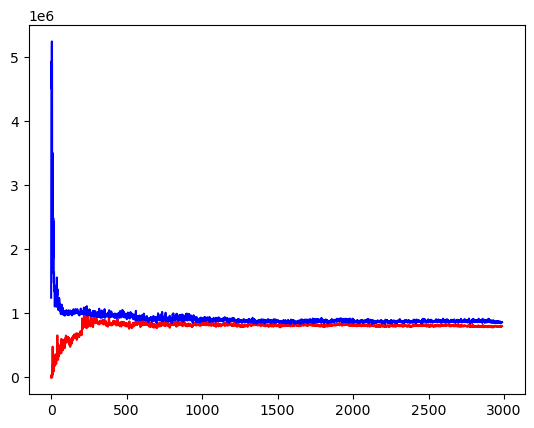

In [321]:
plot_lc(ada,X_train_scaled,y_train)

In [114]:
# ARD

model = ARDRegression(n_iter=1000)


mod_params = {
    'alpha_1': [1e6,1e7,1e8,1e9,1e10,1e11,1e12],
    'alpha_2': [1e-30,1e-25,1e-20,1e-15],
    'lambda_1': [1e-35,1e-32,1e-30,1e-28],
    'lambda_2': [1e3,1e4,1e5,1e6]
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
ard = model_cv.best_estimator_

mod_imp(ard)

Fitting 15 folds for each of 448 candidates, totalling 6720 fits
Mean: 536347.9233470439
STD: 90786.71809091064


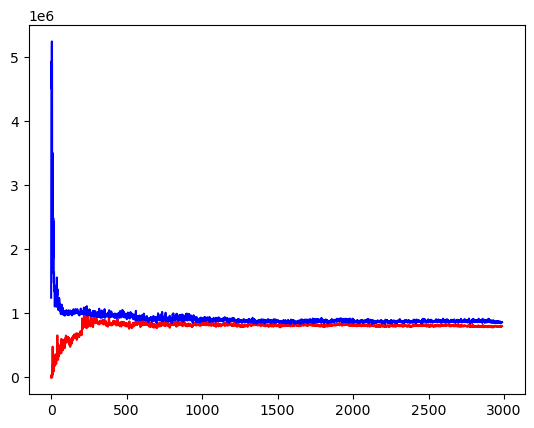

In [332]:
plot_lc(ada,X_train_scaled,y_train)

In [115]:
lasso = LassoCV(max_iter=5000, cv=15,n_jobs=-1,
               random_state=42)
mod_imp(lasso)

Mean: 536590.5521700846
STD: 90149.71650413961


In [116]:
ridge = RidgeCV()
mod_imp(ridge)

Mean: 536710.6734551302
STD: 89918.10812301812


In [117]:
# Poly SVM

model = SVR(kernel='poly')


mod_params = {
    'C': np.arange(.4,.5,.01),
    'epsilon': np.arange(0.3,.4,0.01)
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
svp = model_cv.best_estimator_

mod_imp(svp)

Fitting 15 folds for each of 110 candidates, totalling 1650 fits
Mean: 902290.5111781439
STD: 138908.3914706791


In [41]:
svp.get_params()

{'C': 0.4900000000000001,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.4000000000000001,
 'gamma': 'scale',
 'kernel': 'poly',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

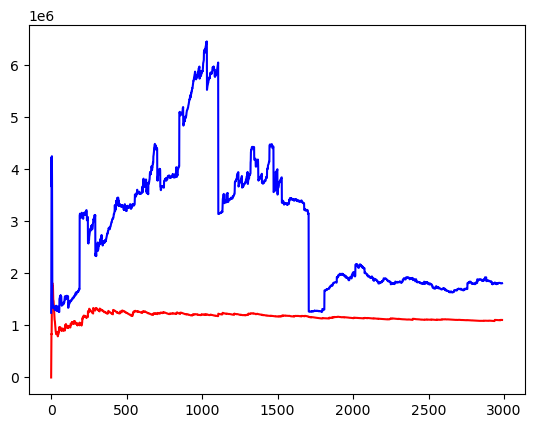

In [340]:
plot_lc(svp,X_train_scaled,y_train)

In [118]:
# KNN

model = KNeighborsRegressor(n_jobs=-1)


mod_params = {
    'n_neighbors': np.arange(30,40,1),
    'weights': ['distance'],
    'p': [1,2]
    
}


model_cv = GridSearchCV(model,mod_params,n_jobs=-1, cv=15, verbose = 1,
                                 scoring='neg_mean_squared_error')
model_cv.fit(X_train_scaled,y_train)
    
knn = model_cv.best_estimator_

mod_imp(knn)

Fitting 15 folds for each of 20 candidates, totalling 300 fits
Mean: 288989.3004259317
STD: 74515.2402376014


In [119]:
# Fit Estimators
gbr.fit(X_train_scaled,y_train)
rfr.fit(X_train_scaled,y_train)
ada.fit(X_train_scaled,y_train)
ard.fit(X_train_scaled,y_train)
lasso.fit(X_train_scaled,y_train)
ridge.fit(X_train_scaled,y_train)
svp.fit(X_train_scaled,y_train)
knn.fit(X_train_scaled,y_train)

KNeighborsRegressor(n_jobs=-1, n_neighbors=30, p=1, weights='distance')

## Weighted VotingRegressor

### Minimize MSE of models

In [120]:
# Specify number of estimators
n_est = 8

# Create a 'weights' array with default values of 1/n_est
w = (1/n_est)*np.ones(n_est)

In [121]:
# Create vector of predicted values from each estimator
gbr_pred = gbr.predict(X_test_scaled)
rfr_pred = rfr.predict(X_test_scaled)
ada_pred = ada.predict(X_test_scaled)
ard_pred = ard.predict(X_test_scaled)
lasso_pred = lasso.predict(X_test_scaled)
ridge_pred = ridge.predict(X_test_scaled)
svp_pred = svp.predict(X_test_scaled)
knn_pred = knn.predict(X_test_scaled)

In [122]:
# Combine prediction vectors into prediction matrix
mod_pred = np.column_stack((gbr_pred,rfr_pred,ada_pred,ard_pred,lasso_pred,ridge_pred,
                            svp_pred,knn_pred))
#mod_pred = np.column_stack((gbr_pred,rfr_pred,lasso_pred,knn_pred))

In [123]:
# Define Objective Function
def obj_fun(weights=w,y_true=y_test,y_hat=mod_pred, n_estimators=n_est):
    return (1/n_est)*np.sum((y_true - (weights@(y_hat.T)))**2)

In [124]:
# Define constraint(s)
def constraints(weights=w):
    return (1- np.sum(np.abs(weights)))

In [125]:
res = optimize.minimize(obj_fun, (1/n_est)*np.ones(n_est), method='SLSQP',
                  constraints={'fun': constraints,
                              'type': 'eq'}, options={'maxiter': 1000})
res

     fun: 20172668.77988167
     jac: array([-4194109.  , -4193730.5 , -4194745.  ,   158165.  ,    49150.25,
          75071.5 ,  2168829.75, -3738568.  ])
 message: 'Optimization terminated successfully'
    nfev: 1027
     nit: 85
    njev: 85
  status: 0
 success: True
       x: array([ 2.62908400e-01,  5.20733207e-01,  2.16334297e-01,  2.00686355e-07,
        2.26767753e-08, -9.52041060e-10,  2.38257355e-08,  2.44065840e-05])

In [126]:
optimal_mod_weights = res.x

In [127]:
# Scale weights

# First argsort returns array with first value is the index of the smallest value
# in the array provided
scaled_weights = np.argsort(optimal_mod_weights)

# Second sort returns array firs value the index of the smallest value of input
# Such that the largest value in optimal_mod_weights will have the largest index
# The resulting array has sorted and scaled from len(array) to 0

scaled_weights = np.argsort(scaled_weights)

# Add 1 to prevent zero weights
scaled_weights = scaled_weights + 1
scaled_weights

array([7, 8, 6, 4, 2, 1, 3, 5], dtype=int64)

### Create VotingRegressor with new weights

In [128]:
estimators = [('gbr',gbr),('rfr',rfr),('ada',ada),('ard',ard),('lasso',lasso),('ridge',ridge),
            ('svp',svp),('knn',knn)]

#estimators = [('gbr',gbr),('rfr',rfr),('lasso',lasso),('knn',knn)]

vrg = VotingRegressor(estimators,
                     weights=scaled_weights,
                     n_jobs=-1)

vrg.fit(X_train_scaled, y_train)

VotingRegressor(estimators=[('gbr',
                             GradientBoostingRegressor(alpha=1e-30,
                                                       learning_rate=0.55,
                                                       max_depth=7,
                                                       max_features='sqrt',
                                                       n_estimators=12,
                                                       random_state=42,
                                                       subsample=0.9650000000000001)),
                            ('rfr',
                             RandomForestRegressor(max_features='sqrt',
                                                   n_estimators=32,
                                                   random_state=42)),
                            ('ada',
                             AdaBoostRegressor(learning_rate=0.13,
                                               n_estimators=14,
                                               random_state=42)),
                            ('...
                                           alpha_2=1e-30, lambda_1=1e-35,
                                           lambda_2=1000.0, n_iter=1000)),
                            ('lasso',
                             LassoCV(cv=15, max_iter=5000, n_jobs=-1,
                                     random_state=42)),
                            ('ridge', RidgeCV()),
                            ('svp',
                             SVR(C=0.4900000000000001,
                                 epsilon=0.4000000000000001, kernel='poly')),
                            ('knn',
                             KNeighborsRegressor(n_jobs=-1, n_neighbors=30, p=1,
                                                 weights='distance'))],
                n_jobs=-1,
                weights=array([7, 8, 6, 4, 2, 1, 3, 5], dtype=int64))

In [129]:
# Compute cv score for comparison
vrg_cvs = cross_val_score(vrg,X_train_scaled,y_train,cv=15,
                         scoring = 'neg_mean_squared_error', n_jobs=-1)

vrg_mean,vrg_std = score_info(vrg_cvs)

Mean: 244199.8159943616
STD: 60185.569395113525


In [130]:
# Display Score on train vs. test
print(f'Training Score: {vrg.score(X_train_scaled, y_train)}')
print(f'Testing Score: {vrg.score(X_test_scaled, y_test)}')

Training Score: 0.8563104425068258
Testing Score: 0.7033499591353478


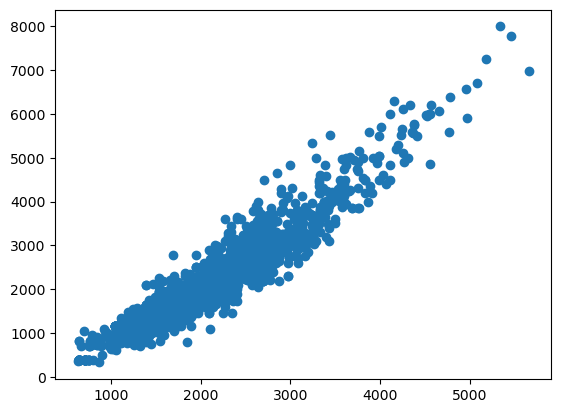

In [131]:
plt.scatter(vrg.predict(X_train_scaled),y_train)
#plt.plot(X_train,vrg.predict(X_train))